In [1]:
#Quora question pair similarity

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup



In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


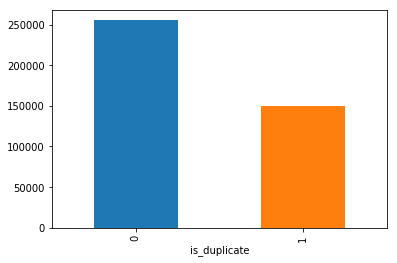

In [5]:
#Exploratory Data analysis

df.groupby("is_duplicate")['id'].count().plot.bar()

In [6]:
print('total number of question pairs for training: {}'.format(len(df)))

total number of question pairs for training: 404290


In [7]:
df['is_duplicate'].mean()

0.369197853026293

In [8]:
percentage_0 =(100-df['is_duplicate'].mean()*100)
percentage_1 = (df['is_duplicate'].mean()*100)
print("number of questions that are not similar {}%".format(percentage_0))
print("number of questions that are similar {}%".format(percentage_1))

number of questions that are not similar 63.0802146973707%
number of questions that are similar 36.9197853026293%


In [9]:
qids=pd.Series(df['qid1'].tolist()+df['qid2'].tolist())
unique_ids=len(np.unique(qids))
#print(unique_ids)
print("number of unique_ids are {}".format(unique_ids))

number of unique_ids are 537933


In [10]:
questionsappearmorethantime = np.sum(qids.value_counts()>1)
print(" UNIQUE questions that appear more than once {}".format(questionsappearmorethantime))

 UNIQUE questions that appear more than once 111780


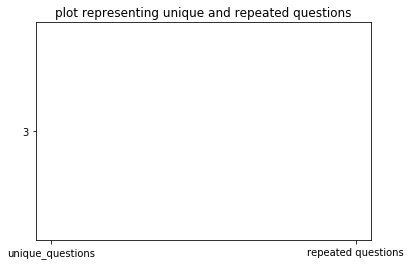

In [11]:
objects='repeated questions','unique_questions'
y_pos=(unique_ids,questionsappearmorethantime)

plt.bar(y_pos,align='center',height = '3',alpha=0.5)
plt.title("plot representing unique and repeated questions")
plt.xticks(y_pos,objects)
#plt.figure(figsize='10,6')
plt.show()

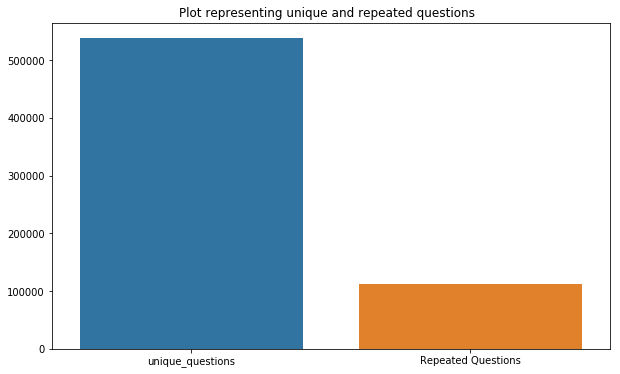

In [12]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_ids , questionsappearmorethantime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

In [13]:
#checking for duplicate number of question pairs(imp)
check_duplicates=df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print("number of duplicate questions:{}".format(check_duplicates.shape[0]-df.shape[0]))

number of duplicate questions:0


Text(0, 0.5, 'number of questions')

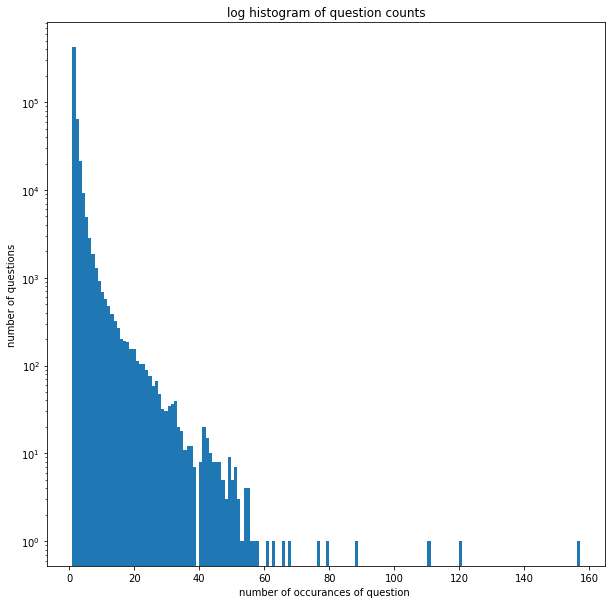

In [14]:
plt.figure(figsize=(10,10))
plt.hist(qids.value_counts(),bins=160)
plt.yscale('log',nonposy='clip')
plt.title('log histogram of question counts')
plt.xlabel('number of occurances of question ')
plt.ylabel('number of questions')

In [15]:
nun_count=[df.isnull().sum().sum()]
print(nun_count)

[3]


In [16]:
df=df.fillna('')

In [17]:
nun_count1=[df.isnull().sum().sum()]
print(nun_count1)


[0]


In [18]:
if os.path.isfile('NLP features without preprocessing.csv'):
    df=pd.read_csv("NLP features without preprocessing.csv",encoding='latin-1')
else:
    df['freq_qid1']=df.groupby('qid1')['qid1'].transform('count')
    df['freq_qid2']=df.groupby('qid2')['qid2'].transform('count')
    df['df1 len']=df['question1'].str.len()
    df['df2_len']=df['question2'].str.len()
    df['q1_nwords']=df['question1'].apply(lambda row:len(row.split(" ")))
    df['q2_nwords']=df['question2'].apply(lambda row:len(row.split(" ")))
    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("NLP features without preprocessing.csv", index=False)

df.head()
                                          
                                          
    
    

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,df1 len,df2_len,q1_nwords,q2_nwords,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [19]:
print("min length of questions in question1",min(df['q1_nwords']))
print("min length of questions in question2",min(df['q2_nwords']))
print("min number of questions in question1", df[df['q1_nwords']== 1].shape[0])
print("min number of questions in question1", df[df['q2_nwords']==1].shape[0])

min length of questions in question1 1
min length of questions in question2 1
min number of questions in question1 67
min number of questions in question1 24


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



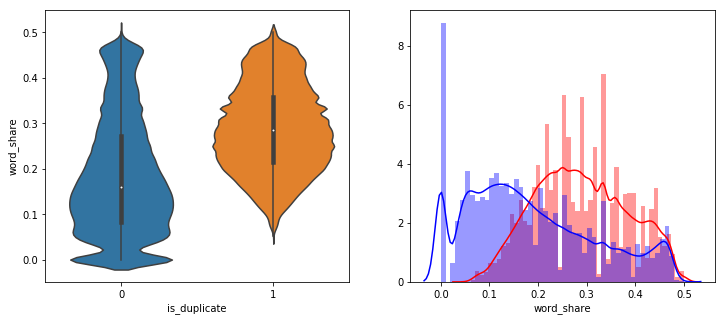

In [20]:
#feature word share:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_share',data=df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

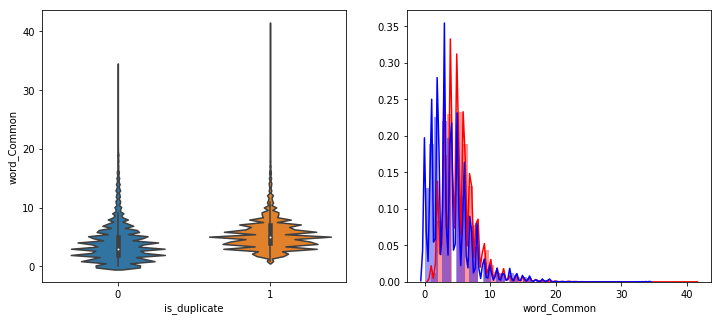

In [21]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_Common',data=df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

In [22]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [23]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,df1 len,df2_len,q1_nwords,q2_nwords,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2
